<a href="https://colab.research.google.com/github/soumitra-dgp/Deep-Learning/blob/main/vgg19_transfer_learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gender Classification from Eye Images

###This is a deep learning project for classifying gender i.e. 'male' and 'female' from eye images.

### Importing required libraries

In [ ]:
#importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical

# Importing image folder from google drive to google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Creating target label sub folders

> ###### The images are given in sub folders 'train' and 'test' along with taining and testing labels in files Training_set.csv and Testing_set.csv. Training_set.csv contains filename and corresponding labels, i.e. 'male' or 'female' aligned with the image files in 'train' directory. Testing_set.csv actually empty, i.e. testing images need to be classified in genders. sample_submission.csv contains the format for submitting the predicted labels. <br>

> ###### Here, a part of 'train' images are moved to a newly created sub folder 'valid'. Both in 'train' and 'valid' folders, two more sub folders named 'male' and 'female' are created. Images in 'train' folder are moved to 'male' and 'female' sub folder according to the labels given in Training_set.csv. The same thing is done for 'valid' sub folder.  
---
> ###### So the directory structure is as below
---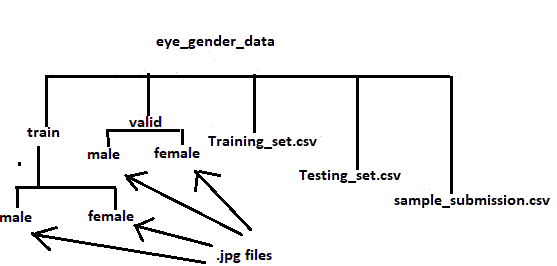


---



# Creating 'valid' folder and 'male' and 'female' subfolders in 'train' and 'valid'

In [ ]:
# Home directory
home_path = r'/content/drive/MyDrive/Dphi_Hackathon/eye_gender_data_2'

# Create train and validation directories
#train_path = os.path.join(home_path,'train')
#os.mkdir(train_path)
val_path = os.path.join(home_path,'valid')
os.mkdir(val_path)

# Create sub-directories
male_train_path = os.path.join(home_path + r'/train','male')
os.mkdir(male_train_path)

female_train_path = os.path.join(home_path + r'/train','female')
os.mkdir(female_train_path)

male_val_path = os.path.join(home_path + r'/valid','male')
os.mkdir(male_val_path)

female_val_path = os.path.join(home_path + r'/valid','female')
os.mkdir(female_val_path)

# Processing training labels

In [ ]:
# Original df
df = pd.read_csv(home_path + r'/Training_set.csv')

In [ ]:
df.head(5)

,filename,label
0,Image_1.jpg,male
1,Image_2.jpg,female
2,Image_3.jpg,female
3,Image_4.jpg,female
4,Image_5.jpg,male


# Separating training image filenames and training labels

In [ ]:
# Images and Labels
X = df.loc[:,'filename']
y = df.loc[:,'label']

In [ ]:
y.head(5)

0      male
1    female
2    female
3    female
4      male
Name: label, dtype: object

# Training and validation image filenames and labels are divided into train and valid 

In [ ]:
# Train-Test splitfor train and validation images
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.2, random_state = 27, stratify=y)

In [ ]:
train_y

8464      male
8750    female
277       male
5267    female
990     female
         ...  
7855    female
1683      male
6993      male
1401      male
3470    female
Name: label, Length: 7376, dtype: object

In [ ]:
print((train_x.shape,train_y.shape))
print((val_x.shape,val_y.shape))

((7376,), (7376,))
((1844,), (1844,))


###### Two new dataframes are formed and populated with image filenames and corresponding labels for 'train' and 'valid' directory

In [ ]:
# Train df
df_train = pd.DataFrame(columns=['filename','label'])
df_train['filename'] = train_x
df_train['label'] = train_y

# Validation df
df_valid= pd.DataFrame(columns=['filename','label'])
df_valid['filename'] = val_x
df_valid['label'] = val_y

# Reset index
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

In [ ]:
df_valid.head(5)

,filename,label
0,Image_2177.jpg,female
1,Image_8340.jpg,male
2,Image_1630.jpg,male
3,Image_4889.jpg,female
4,Image_271.jpg,male


In [ ]:
print((df_train.shape))
print((df_valid.shape))

(7376, 2)
(1844, 2)


###### In both the dataframes, 'male' labels are replaced with 1 and 'female' labels are replaced with 0

In [ ]:
df_train['label'].replace(['male','female'],[1, 0], inplace=True)
df_valid['label'].replace(['male','female'],[1, 0], inplace=True)

###### According to label values (1 for 'male' and 0 for 'female') df_train and df_valid, corresponding images are moved to male and female sub folders in train and valid directory 

In [ ]:
# Save train images
import shutil


for i in range(len(df_train)):
  image = df_train.loc[i,'filename']
  if df_train.loc[i,'label'] == 0:
    shutil.move(home_path + '/train/' + image, female_train_path)
  else:
    shutil.move(home_path + '/train/' + image, male_train_path)
        
# Save validation images
for i in range(len(df_valid)):

    image = df_valid.loc[i,'filename']

    if df_valid.loc[i,'label'] == 0:
        shutil.move(home_path + '/train/' + image, female_val_path)
    else:
        shutil.move(home_path + '/train/' + image, male_val_path)


In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
import keras
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# VGG19 model is downloaded  

In [ ]:
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, 
                                               input_shape=(32,32,3), classes = df_train.shape[1])

80142336/80134624 [==============================] - 1s 0us/step


##### Existing weights and biases are not considered and the VGG19 model is trained again

In [ ]:
for layer in vgg_layers.layers:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7eff15a68e90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7eff15a93cd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7eff15a32510> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7eff15a02cd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efec81c0410> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efec81c49d0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7efec81c7490> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efec81c9c10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efec81d4150> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efec81c7e50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efec81c7750> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7efec816b

###### The model used is defined in define_model() function. Training and validation loss as well as training and validation accuracy are plotted in another function. The run_test_validity() function loads data using ImageDataGenerator, trains the model and the resulting model is saved.

Found 7376 images belonging to 2 classes.
Found 1844 images belonging to 2 classes.
Epoch 1/30
116/116 [==============================] - 15s 105ms/step - loss: 0.5051 - accuracy: 0.7476 - val_loss: 0.3075 - val_accuracy: 0.8633
Epoch 2/30
116/116 [==============================] - 12s 103ms/step - loss: 0.3190 - accuracy: 0.8717 - val_loss: 0.1951 - val_accuracy: 0.9235
Epoch 3/30
116/116 [==============================] - 13s 109ms/step - loss: 0.2042 - accuracy: 0.9239 - val_loss: 0.2519 - val_accuracy: 0.8997
Epoch 4/30
116/116 [==============================] - 12s 105ms/step - loss: 0.2006 - accuracy: 0.9264 - val_loss: 0.1597 - val_accuracy: 0.9371
Epoch 5/30
116/116 [==============================] - 12s 100ms/step - loss: 0.1675 - accuracy: 0.9367 - val_loss: 0.1496 - val_accuracy: 0.9420
Epoch 6/30
116/116 [==============================] - 12s 99ms/step - loss: 0.1463 - accuracy: 0.9451 - val_loss: 0.1840 - val_accuracy: 0.9219
Epoch 7/30
116/116 [===========================

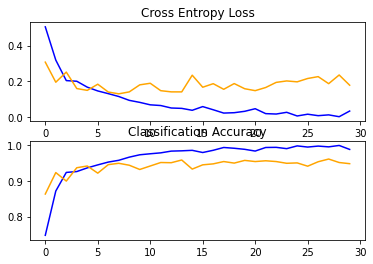

In [ ]:
import sys
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
# define cnn model
def define_model():
  model = tf.keras.models.Sequential()
  # Add the vgg convolutional base model
  model.add(vgg_layers)
  # add flatten layer
  model.add(tf.keras.layers.Flatten())
  
  # add dense layers with some dropout
  model.add(tf.keras.layers.Dense(256, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.3))
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.3))

  # add output layer
  model.add(tf.keras.layers.Dense(2, activation='softmax'))
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # plot loss
  pyplot.subplot(211)
  pyplot.title('Categorical Entropy Loss')
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='orange', label='valid')
  # plot accuracy
  pyplot.subplot(212)
  pyplot.title('Classification Accuracy')
  pyplot.plot(history.history['accuracy'], color='blue', label='train')
  pyplot.plot(history.history['val_accuracy'], color='orange', label='valid')

# run the test harness for evaluating a model
def run_test_validity():
  # define model
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(rescale=1.0/255.0)
  
  #rmtrainpath = '/content/drive/MyDrive/Dphi_Hackathon/eye_gender_data_2/train/.ipynb_checkpoints'
  #if(rmtrainpath):
  #  os.rmdir(rmtrainpath)
  #rmvalpath = '/content/drive/MyDrive/Dphi_Hackathon/eye_gender_data_2/valid/.ipynb_checkpoints'
  #if(rmvalpath):
  #  os.rmdir(rmvalpath)
  # prepare iterators
  train_it = datagen.flow_from_directory('/content/drive/MyDrive/Dphi_Hackathon/eye_gender_data_2/train',
                                         batch_size=64, target_size=(32, 32))
  val_it = datagen.flow_from_directory('/content/drive/MyDrive/Dphi_Hackathon/eye_gender_data_2/valid',
                                        batch_size=64, target_size=(32, 32))
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=val_it, validation_steps=len(val_it), epochs=30, verbose=1)
  model.save('/content/drive/MyDrive/Dphi_Hackathon/eye_gender_data_2/test_model_1.h5')
  summarize_diagnostics(history)
# entry point, run the test harness
run_test_validity()

# Test images are loaded into memory and normalized

In [ ]:
import pandas as pd
test = pd.read_csv(home_path + '/Testing_set.csv')

In [ ]:
from keras.preprocessing import image
test_image = []
for i in tqdm(range(test.shape[0])):
    img = image.load_img('/content/drive/MyDrive/Dphi_Hackathon/eye_gender_data_2/test/' + test['filename'][i],target_size=(32,32,3),grayscale=False)
    img = image.img_to_array(img)
    test_image.append(img)
X_test = np.array(test_image, dtype='float') / 255.0

100%|██████████| 2305/2305 [13:44<00:00,  2.80it/s]


# Predicting test images

In [ ]:
#Making prediction
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Dphi_Hackathon/eye_gender_data_2/test_model_1.h5')
y_pred = model.predict(X_test)
y_pred[:5]

array([[1.1183914e-04, 9.9988818e-01],
       [6.5423123e-04, 9.9934572e-01],
       [1.6710615e-03, 9.9832898e-01],
       [1.0992861e-02, 9.8900712e-01],
       [2.9965902e-05, 9.9997008e-01]], dtype=float32)

# Generating predicting labels

In [ ]:
prediction_labels = np.argmax(y_pred, axis=1)
prediction_labels[:5]

array([1, 1, 1, 1, 1])

# Predictions are saved in sample_submission_N2.csv

In [ ]:
sample = pd.read_csv(home_path + '/sample_submission.csv')
#print(sample)
sample['label'] = prediction_labels
#sample.to_csv(data_folder + '/sample_submission1.csv', header=True, index=False)
#sample_cnn1 = pd.read_csv(data_folder + '/sample_submission1.csv')
sample['label'].replace(0,'female',inplace=True)
sample['label'].replace(1,'male',inplace=True)
print(sample)
sample.to_csv(home_path + '/sample_submission_N2.csv',header=True,index=False)

       label
0       male
1       male
2       male
3       male
4       male
...      ...
2300  female
2301  female
2302    male
2303    male
2304    male

[2305 rows x 1 columns]


##### Reference
Deep Learning for Computer Vision by Jason Brownlee

Accuracy: 95.1844